c:\Users\lc100\AppData\Local\miniconda3\envs\frameSubtraction\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\lc100\AppData\Local\miniconda3\envs\frameSubtraction\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\lc100\AppData\Local\miniconda3\envs\frameSubtraction\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



very blurry
(32, 32, 3)
(32, 32, 3)


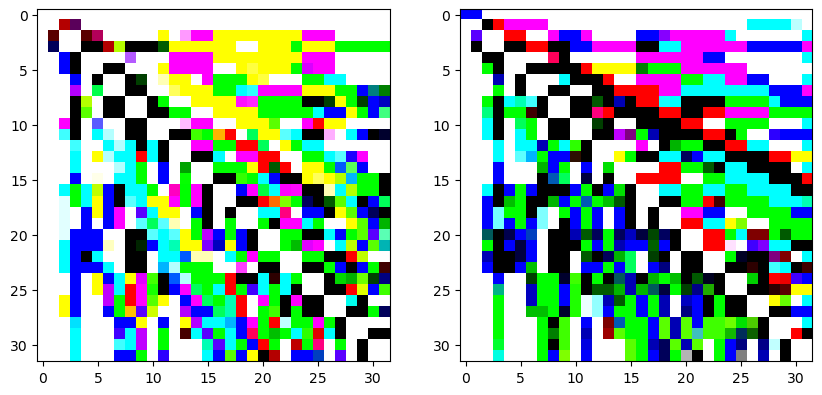

29.499999999999996
29.499999999999996
29.999999999999993
28.999999999999996
---------------------------------------------------------------------------------------------
[[[29.5 61.  70. ]
  [30.  61.  70. ]]

 [[29.5 61.5 69.5]
  [29.  64.  70. ]]] 
------
 [[[  0.    0.  127.5]
  [  0.    0.  127. ]]

 [[ 15.    6.  127.5]
  [ 15.    6.  127.5]]]

------
 107.83333333333333
---------------------------------------------------------------------------------------------


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch


from ipynb.fs.full.subtraction import boundingBoxes,display,drawContour,substraction,substractionSAD
from ipynb.fs.full.checkB import checkBoxes,checkBlob,initBlobDetect
from ipynb.fs.full.wavelet import middle,Wavelet
from ipynb.fs.full.ransac import RANSACcoude,plotLines,drawLines
from ipynb.fs.full.white_select import selectWhite,selectWhiteHSV
#from ipynb.fs.full.particle_track import particlesDetect,initialize_particles
from ipynb.fs.full.particle_Wave import particlesDetect,initialize_particles

In [2]:
def detect_ball(model, frame: np.ndarray):
    WIDTH = 360
    HEIGHT = 360
    resized_frame = cv2.resize(frame, (WIDTH, HEIGHT))
    detection = model(resized_frame)
    bounding_box = detection.xyxy[0].numpy()

    for box in bounding_box:
        if box[5] == 0:
            x = box[0] + (box[2] - box[0]) / 2
            y = box[1] + (box[3] - box[1]) / 2
            return (int(x), int(y)), (box[0], box[1], box[2], box[3])
            # array([     124.15,         179,      130.78,      185.98,      0.8651,           0], dtype=float32)
            # box[0]:   Left
            # box[1]:   Top
            # box[2]:   Right
            # box[3]:   Bottom
            # box[4]:   Probability
            # box[5]:   Klasse 0 = Ball

    return False, False

ball_model = torch.hub.load('ultralytics/yolov5', 'custom', path='03_Ball_Detection/models/ball_weights_V2.pt', force_reload=False)

def detect_ball_static(image,model=ball_model):

    height, width, _ = image.shape

    # start object detection
    # ball detection returns center coordinates from the ball
    ball_center, ball_bb = detect_ball(model, image)
    size=360
    if ball_center:  
        ball_center = [ball_center[0] * (width / size), ball_center[1] * (height / size)] 
        ball_bb=[int(ball_bb[0]* (width / size)),
                int(ball_bb[1]* (height / size)),
                int(ball_bb[2]* (width / size)),
                int(ball_bb[3]* (height / size))]  
        
        return [ball_bb[0],ball_bb[1],ball_bb[2]-ball_bb[0]+20,ball_bb[3]-ball_bb[1]+20]
    return None

Using cache found in C:\Users\lc100/.cache\torch\hub\ultralytics_yolov5_master


In [ ]:

%matplotlib qt

In [ ]:
# 2 frames for the substraction
frame1=None #newest frame
frame0=None #previous frame

background=None

# 1st frame will be use to detect the white borders of the field
first_frame=None
white_border=None

# time jump between 2 frame
jump=100 #60
# index is the time of the frame
idx=jump*2

#3D points (x,y,t,type)
wavePoint=[[0,0,0,0]]
#3D Blob points (x,y,t,type)
blobPoint=[[0,0,0,0]]
#3D points particle(x,y,t)
particlePoint=[[0,0,0]]

#3D points wavePoint+particlePoint (x,y,t,type), 0=move, 1=static, 2=particle
allPoints=[[0,0,0,0]]


#number of pts used for RANSAC
size_slice=30 #40  #20
#dist min for RANSAC
distMinRANSAC=30 #35 #30     #25 #20 #70
#min pts for Ransac being correct
minPtsRansac=float(size_slice)*1/3
#min pts on each branche
Wbranche=5
#pts after ransac
corrected=np.array([[0,0,0,0]])
#pts after correction of the trajectory
corrected2=np.array([[0,0,0,0]])
# index of the last pts that had is trajectory corrected in corrected[]
lastcorrected=0 
firstLoop=True
lastLen=0

# all the lines found by RANSAC
all_lines=[ [ [[0,0,0],[0,0,0]],[[0,0,0],[0,0,0]] ] ]
#all_lines=[[[0,0,0],[0,0,0]]]

model=None
lastwavePoint=None

static=False
static_box=None


#templates used for the wavelet function templateOutput
#template = cv2.imread('template/templateOutput.png')
template = cv2.imread('template/templateRGB_both.png')
template_W= Wavelet(template)

templateB = cv2.imread('template/templateB.png')
template_B = Wavelet(templateB)

#video
cap = cv2.VideoCapture('video_record/1310.mp4')
# Check if camera opened successfully
if (cap.isOpened()== False): 
    print("Error opening video stream or file")
    

# Capture frame-by-frame
ret, frame_og= cap.read()


#particle detect
W=1700#np.shape(frame_og)[1]
H=np.shape(frame_og)[0]
print(W,H)
N=50 #wave=50
VEL=40.0
POS_SIGMA = 60.0
particles = initialize_particles(N=N,width=W,height=H,velocity=VEL)

detector=initBlobDetect()


1700 1080


In [ ]:
#Read until video is completed
while(cap.isOpened()):
    
    # Capture frame-by-frame
    ret, frame_og= cap.read()
    
    if ret == True:
        model=None
        
        frame_og_crop=frame_og[:,:1700,:].copy()
        last_frame = frame_og_crop.copy()

        #detect the white border so to not confuse them with the ball ######################################################################################################################################
        if first_frame is None:
            frame0 = frame_og_crop.copy()
            frame1 = frame_og_crop.copy()
            
            background = frame_og_crop.copy()
            background = cv2.medianBlur(background, 21)
            background = cv2.cvtColor(background, cv2.COLOR_BGR2YCR_CB)
            #background = background[:,:,0]
            background = background.astype('float32')
            
            first_frame = frame_og_crop.copy()
            white_border=selectWhite(first_frame,dilate=9,erode=2)

            white_border=cv2.bitwise_not(white_border)

            #display(white_border,name='not border')

    
        frame0 = frame1.copy()
        frame1 = frame_og_crop.copy()

        #white select
        #maskW1=selectWhite(frame1,erode=3,dilate=8,B_limit=70)
        #maskW0=selectWhite(frame0,erode=3,dilate=8,B_limit=70)

        #maskW=cv2.bitwise_or(maskW1, maskW0, mask = None)
        #maskW=cv2.bitwise_and(maskW,white_border, mask=None)
        #maskW = cv2.erode(maskW, None, iterations=4)
        #maskWA = cv2.dilate(maskW, None, iterations=15)
        
        #frame_white=cv2.bitwise_and(frame_og_crop.copy(),frame_og_crop.copy(), mask=maskW)
        #display(frame_white,name='white mask RGB')
        
        
        #substraction ######################################################################################################################################
        frameHLS0=cv2.cvtColor(frame0,cv2.COLOR_BGR2YUV)
        frameHLS1=cv2.cvtColor(frame1,cv2.COLOR_BGR2YUV)
        
        frame_substraction=substraction(frameHLS0[:,:,0],frameHLS1[:,:,0],blur_type=1,blur=21,threshold_type=0,threshold=15,show=False,erode=4,dilate=10)
        
        dil,contours=drawContour(frame_substraction,kernelsize=25)
        #display(dil,name='dilatation')
        #put boxes around objects
        maskRec,boundRect=boundingBoxes(contours,show=False,width=W,height=H)
        #detect the ball in one of the boxes (if any)
        box = checkBoxes(frame_og_crop.copy(),boundRect,coeff=15.0,wave_temp=template_W,wave_temp2=template_B,show=False) #coeff=15
        
        
        #Subtraction background and blob ######################################################################################################################################
        
        background,frame_subBackground =substractionSAD(background,frame0.copy(),frame1.copy(),idx//jump,show=True,blur=15,threshold=10.0)
        #frame_subBackground = cv2.bitwise_and(frame_substraction , white_border, mask=None)
        
        ptsBlob=checkBlob(detector,frame_subBackground,frame1.copy(),idx,show=True)
        
        if ptsBlob is not None:
            allPoints=np.concatenate((allPoints,ptsBlob))
            blobPoint=np.concatenate((blobPoint,ptsBlob))
          
            
        #white select ######################################################################################################################################
        """
        maskW_sub=cv2.bitwise_and(frame_og_crop.copy(), frame_og_crop.copy(), mask=dil)
        maskW_sub=selectWhite(maskW_sub,erode=3,dilate=8,B_limit=60,W_limit=100,H_limit=20)

        maskW = cv2.bitwise_and(maskW_sub , white_border, mask=None)
        maskW = cv2.erode(maskW, None, iterations=4)
        maskW = cv2.dilate(maskW, None, iterations=6)
        
        whiteANDsub=cv2.bitwise_and(frame_og_crop.copy(),frame_og_crop.copy(), mask=maskW)
        display(whiteANDsub,name='select white')
        """
        
        #particle ######################################################################################################################################
        
        #static boxes
        #if static_box is not None:
        #   cv2.rectangle(maskRec, (int(static_box[0]), int(static_box[1])),(int(static_box[0]+static_box[2]), int(static_box[1]+static_box[3])),1, -1)
        
        frameRGB = frame_og_crop.copy()
        frameRGB=cv2.bitwise_and(frameRGB, frameRGB, mask=maskRec)
        particles,terminate,location=particlesDetect(particles,frameRGB,frame_og_crop.copy(),N=N,width=W,height=H,sigma=POS_SIGMA)
        location=None
        
        """
        #Color
        frameHLS= cv2.cvtColor(frameRGB,cv2.COLOR_BGR2HLS)
        frameHLS=cv2.bitwise_and(frameHLS, frameHLS, mask=white_border)
        
        TARGET_COLOUR_WHITE_HLS = np.array((200,255,40))
        DIFF_COLOR_HLS=(160,70,40) # lower color= target-diff
        
        #TARGET_COLOUR_WHITE = np.array((255,255,255))
        #DIFF_COLOR=(120,120,120) # lower color= target-diffq
        
        particles,terminate,location=particlesDetect(particles,frameHLS,N=N,width=W,height=H,sigma=POS_SIGMA,colour=TARGET_COLOUR_WHITE_HLS,diff_color=DIFF_COLOR_HLS)
        """
        
        if location is not None:
            P=[location[1],location[0],idx]
            particlePoint=np.append(particlePoint,[P],axis=0) 
            
            b=[location[1],location[0],idx,0.0]
            allPoints=np.append(allPoints,[b],axis=0)  
            
        
        
        #static detection ######################################################################################################################################
        if (box is None and not static) : #did not detected moving ball, static mode on
            static=True    
            box=detect_ball_static(frame_og_crop.copy(),ball_model)     
            static_box= box
        elif box is None and static_box is not None: # still not moving, use the last detection
            box=static_box
        else: # moving, static mode off
            static_box=None
            static=False   
        
        # add the 3D to the points
        if box is not None:
            pts=middle(box)
            
            # if same wavePoint, don't take it.
            if not np.array_equal(pts, wavePoint[-1][:2]) and ((pts[0]-wavePoint[-1][0])**2+(pts[1]-wavePoint[-1][1])**2)>70:
                if static:
                    P=[pts[0],pts[1],idx,1.5]
                else:
                    P=[pts[0],pts[1],idx,0.75]
                wavePoint=np.append(wavePoint,[P],axis=0) 
                allPoints=np.append(allPoints,[P],axis=0) 

            cv2.rectangle(frame_og_crop, (int(box[0]), int(box[1])),(int(box[0]+box[2]), int(box[1]+box[3])), (255,255,255), 2) 
            


        #Ransac ######################################################################################################################################
        
        #tab=wavePoint
        tab=allPoints
        
        Len=len(allPoints)
        #Len1=len(wavePoint)
        
        if Len%size_slice==0 and lastLen!=Len:
            
            if firstLoop:
                tab=tab[1:]

            sliced=tab[(Len-size_slice):]
            
            
            if model is not None:
                sliced=np.concatenate((corrected[len(corrected)-5:],sliced))
            elif firstLoop==False:
                sliced=np.concatenate((tab[(Len-5-size_slice):(Len-1-size_slice)],sliced))
            
            sliced=np.concatenate((tab[(Len-10-size_slice):(Len-1-size_slice)],sliced))
            
            model,droite=RANSACcoude(sliced,N=sliced.shape[0]**2,distanceMin=distMinRANSAC,wheightBranche=Wbranche,minPts=minPtsRansac)
            lastLen=Len

            if model is not None:
                corrected=np.concatenate((corrected,model))
                all_lines=np.append(all_lines,[droite],axis=0)
                

                if firstLoop:
                    corrected=corrected[1:]
                    all_lines=all_lines[1:]
                    
      
        # correct trajectory: if i is shorter to go to the jumpCth pts rather than the next then we jump ####################################################
        
        k=lastcorrected
        lenCorrect=len(corrected)
        jumpC=3
        """
        while k < (lenCorrect-5) :
            diff1=cv2.absdiff(corrected[k],corrected[k+1])
            diff2=cv2.absdiff(corrected[k],corrected[k+jumpC])
            corrected2=np.append(corrected2,[corrected[k]],axis=0)

            if diff1[0]+diff1[1]*1 < (diff2[0]+diff2[1]):
                k+=1
            else:
                k+=jumpC-1
        """
        if firstLoop and model is not None:
            corrected2=corrected2[1:]
            firstLoop=False
        if lenCorrect>5:
            lastcorrected = lenCorrect-jumpC
        
        


        #plot######################################################################################################################################
          
        for index, item in enumerate(particlePoint): 
            cv2.circle(frame_og_crop, (int(item[0]),int(item[1])), 2, [20, 225, 255], 5)
        for index, item in enumerate(wavePoint): 
            if item[3]==0.75: #green is moving
                cv2.circle(frame_og_crop, (int(item[0]),int(item[1])), 2, [20, 255, 20], 5)
            else: # blue is static
                cv2.circle(frame_og_crop, (int(item[0]),int(item[1])), 2, [255, 200, 50], 5)
        for index, item in enumerate(blobPoint): 
            cv2.circle(frame_og_crop, (int(item[0]),int(item[1])), 2, [200, 80, 255], 5)
            
        """
        for index, item in enumerate(allPoints): 
            cv2.circle(frame_og_crop, (int(item[0]),int(item[1])), 2, [20, 255, 20], 5)
        """    
             
        #plotLines(particlePointointoint,frame=frame_og_crop,disappear=True,limit=20) 
        #plotLines(wavePoint,frame=frame_og_crop,disappear=False)
        #plotLines(corrected,frame=frame_og_crop,disappear=False) 
        drawLines(all_lines,frame_og_crop,thick=distMinRANSAC)
        #plotLines(corrected2,frame=frame_og_crop,disappear=False,color= [255, 10, 10]) 
        
        for index, item in enumerate(corrected): 
            cv2.circle(frame_og_crop, (int(item[0]),int(item[1])), 2, [20, 20, 255], 5)

        display(frame_og_crop,name='detection')
        
        idx+=jump
        
        #if idx==58600:
        
            
        #next loop ######################################################################################################################################
        """
        #press key to go the next frame or Q to exit or S to save the frame
        key = cv2.waitKey(0)
        
        if key == ord('q') or key == ord('Q'):
            break
        elif key == ord('s') or key == ord('S'):
            #box_cp = frame_og[box[1]:(box[1]+box[3]),box[0]:(box[0]+box[2]),:]
            #cv2.imwrite("object1_{}.png".format(idx), box_cp)
            cv2.imwrite("image.png", frame_og_crop)
        else:
            continue
        """
            
        
        if cv2.waitKey(1)==27:
            if not cv2.waitKey(1)==27:
                break
            
  # Break the loop
    else: 
        break
    



blob green: 1676.0
blob green: 1646.0
blob green: 1713.0
blob green: 1936.0
blob green: 3080.0
blob green: 2116.0
blob green: 1936.0
blob green: 2039.0
blob green: 1936.0
blob green: 2603.0
blob green: 3495.0
blob green: 3111.0
blob green: 2807.0
blob green: 2804.0
blob green: 2839.0
blob green: 2738.0
blob green: 2597.0
blob green: 2507.0
blob green: 2145.0
blob green: 2006.0
blob green: 1952.0
blob green: 1548.0
blob green: 1787.0
blob green: 1683.0
blob green: 1977.0
blob green: 1556.0
blob green: 1647.0
blob green: 1601.0
blob green: 2537.0
blob green: 1960.0
blob green: 1939.0
blob green: 2151.0
blob green: 1539.0
blob green: 1673.0
blob green: 2125.0
blob green: 2633.0
blob green: 3102.0
blob green: 1917.0
blob green: 3460.0
blob green: 1564.0
blob green: 3130.0
blob green: 2513.0
blob green: 2573.0
blob green: 2656.0
blob green: 1736.0
blob green: 2796.0
blob green: 2017.0
blob green: 2031.0
blob green: 2040.0
blob green: 2125.0
blob green: 2208.0
blob green: 2004.0
blob green: 

KeyboardInterrupt: 

In [ ]:

# Closes all the frames
#cv2.destroyAllWindows()

"""
for index, item in enumerate(wavePoint): 
    if not item[3]: #green is moving
        cv2.circle(frame_og_crop, item[:2], 2, [20, 255, 20], 5)
    else: # blue is static
        cv2.circle(frame_og_crop, item[:2], 2, [255, 200, 50], 5)
plotLines(corrected,frame=frame_og_crop,disappear=False) # draw boxe selected
cv2.imwrite("image.png", frame_og_crop)

print(wavePoint.shape)
"""

'\nfor index, item in enumerate(wavePoint): \n    if not item[3]: #green is moving\n        cv2.circle(frame_og_crop, item[:2], 2, [20, 255, 20], 5)\n    else: # blue is static\n        cv2.circle(frame_og_crop, item[:2], 2, [255, 200, 50], 5)\nplotLines(corrected,frame=frame_og_crop,disappear=False) # draw boxe selected\ncv2.imwrite("image.png", frame_og_crop)\n\nprint(wavePoint.shape)\n'

In [ ]:
fig = plt.figure(figsize = (8,8)) ######################################################################################################################################
ax = fig.add_subplot(111, projection='3d')
ax.grid()

#ax.scatter(allPoints[:,1],allPoints[:,0],allPoints[:,2],marker="+",color='g')
#ax.scatter(corrected[:,1],corrected[:,0],corrected[:,2],marker="o",color='r')

ax.scatter(wavePoint[:,1],wavePoint[:,0],wavePoint[:,2],marker="o",color='g')
#ax.scatter(particlePoint[:,1],particlePoint[:,0],particlePoint[:,2],marker="+")
ax.scatter(blobPoint[:,1],blobPoint[:,0],blobPoint[:,2],marker=",")

#for index, item in enumerate(wavePoint): 
#     if (item[2]//jump)%15==0:
#          ax.scatter(item[1],item[0],item[2],marker="o",color='r')


ax.set_ylabel('x', labelpad=20)
ax.set_ylim(0, 1700)
ax.set_xlabel('y', labelpad=20)
ax.set_xlim(0, 1100)
ax.set_zlabel('t', labelpad=20)
#ax.set_zlim(0, 100)

fig2 = plt.figure(figsize = (8,8)) ######################################################################################################################################
ax2 = fig2.add_subplot(111, projection='3d')
ax2.grid()
ax2.scatter(corrected[:,1],corrected[:,0],corrected[:,2],marker='+',color='g')

for item in all_lines:
     start_pts=item[0][0]
     middle_pts=item[0][1]
     end_pts=item[1][1]
     
     ax2.scatter(middle_pts[1],middle_pts[0],middle_pts[2],color='g')
     ax2.scatter(end_pts[1],end_pts[0],end_pts[2],color='b')
     ax2.scatter(start_pts[1],start_pts[0],start_pts[2],color='r')
     
     ax2.plot([start_pts[1], middle_pts[1]], [start_pts[0], middle_pts[0]], zs=[start_pts[2], middle_pts[2]],color='k')
     ax2.plot([end_pts[1], middle_pts[1]], [end_pts[0], middle_pts[0]], zs=[end_pts[2], middle_pts[2]],color='k')

ax2.set_ylabel('x', labelpad=20)
ax2.set_ylim(0, 1700)
ax2.set_xlabel('y', labelpad=20)
ax2.set_xlim(0, 1100)
ax2.set_zlabel('t', labelpad=20)

"""
fig = plt.figure(figsize = (8,8)) ######################################################################################################################################

plt.plot(corrected[:,2],corrected[:,1],'g')
plt.plot(corrected[:,2],corrected[:,0],'r')
plt.plot(corrected[:,2],corrected[:,1],'g+')
plt.plot(corrected[:,2],corrected[:,0],'r+')

fig = plt.figure(figsize = (8,8)) ######################################################################################################################################

plt.plot(corrected2[:,2],corrected2[:,1],'k')
plt.plot(corrected2[:,2],corrected2[:,0],'b')

plt.show()

"""

key = cv2.waitKey(0)
#When everything done, release the video capture object
cap.release()  
# Closes all the frames
cv2.destroyAllWindows()

In [ ]:
"""
#classifier = keras_cv.models.ImageClassifier.from_preset(
#    "efficientnetv2_b0_imagenet_classifier"
#)

image = keras.utils.load_img("Imageterrain.jpg")
image = np.array(image)
keras_cv.visualization.plot_image_gallery(
    [image], rows=1, cols=1, value_range=(0, 255), show=True, scale=4
)
predictions = classifier.predict(np.expand_dims(image, axis=0))
top_classes = predictions[0].argsort(axis=-1)
classes = keras.utils.get_file(
    origin="https://gist.githubusercontent.com/LukeWood/62eebcd5c5c4a4d0e0b7845780f76d55/raw/fde63e5e4c09e2fa0a3436680f436bdcb8325aac/ImagenetClassnames.json"
)
with open(classes, "rb") as f:
    classes = json.load(f)
top_two = [classes[str(i)] for i in top_classes[-2:]]
print("Top two classes are:", top_two)
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE
tfds.disable_progress_bar()

data, dataset_info = tfds.load("cats_vs_dogs", with_info=True, as_supervised=True)
train_steps_per_epoch = dataset_info.splits["train"].num_examples // BATCH_SIZE
train_dataset = data["train"]

num_classes = dataset_info.features["label"].num_classes

resizing = keras_cv.layers.Resizing(
    IMAGE_SIZE[0], IMAGE_SIZE[1], crop_to_aspect_ratio=True
)


def preprocess_inputs(image, label):
    image = tf.cast(image, tf.float32)
    # Staticly resize images as we only iterate the dataset once.
    return resizing(image), tf.one_hot(label, num_classes)


# Shuffle the dataset to increase diversity of batches.
# 10*BATCH_SIZE follows the assumption that bigger machines can handle bigger
# shuffle buffers.
train_dataset = train_dataset.shuffle(
    10 * BATCH_SIZE, reshuffle_each_iteration=True
).map(preprocess_inputs, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)

images = next(iter(train_dataset.take(1)))[0]
keras_cv.visualization.plot_image_gallery(images, value_range=(0, 255))
#setting the path to the directory containing the pics
path = 'G:\\06  Projekte\\72 KI\\01 Studenten\\2023_06_Couture\\ball_tracking\\object_detected'
#appending the pics to the training data list
training_data = [] 
borderType = cv2.BORDER_CONSTANT
value = [0, 0, 0]
size=64

for img in os.listdir(path):
    pic = cv2.imread(os.path.join(path,img))
    """"""
    more=(size- pic.shape[0])
    top = 0
    bottom = more
    more1=(size- pic.shape[1])
    left = 0
    right = more1
    
    a = cv2.copyMakeBorder(pic, top, bottom, left, right, borderType,value=value)
    """"""
    
    pic = cv2.resize(pic,(size,size))
    training_data.append([pic])
    
#converting the list to numpy array and saving it to a file using #numpy.save
np.save(os.path.join("./",'aaa_false_set'),np.array(training_data))
#loading the saved file once again
saved = np.load(os.path.join("./",'aaa_data_set.npy'))
print(saved.shape)
plt.imshow(saved[0].reshape(size,size,3))
plt.imshow(np.array(training_data[0]).reshape(size,size,3))
"""


'\n#classifier = keras_cv.models.ImageClassifier.from_preset(\n#    "efficientnetv2_b0_imagenet_classifier"\n#)\n\nimage = keras.utils.load_img("Imageterrain.jpg")\nimage = np.array(image)\nkeras_cv.visualization.plot_image_gallery(\n    [image], rows=1, cols=1, value_range=(0, 255), show=True, scale=4\n)\npredictions = classifier.predict(np.expand_dims(image, axis=0))\ntop_classes = predictions[0].argsort(axis=-1)\nclasses = keras.utils.get_file(\n    origin="https://gist.githubusercontent.com/LukeWood/62eebcd5c5c4a4d0e0b7845780f76d55/raw/fde63e5e4c09e2fa0a3436680f436bdcb8325aac/ImagenetClassnames.json"\n)\nwith open(classes, "rb") as f:\n    classes = json.load(f)\ntop_two = [classes[str(i)] for i in top_classes[-2:]]\nprint("Top two classes are:", top_two)\nBATCH_SIZE = 32\nIMAGE_SIZE = (224, 224)\nAUTOTUNE = tf.data.AUTOTUNE\ntfds.disable_progress_bar()\n\ndata, dataset_info = tfds.load("cats_vs_dogs", with_info=True, as_supervised=True)\ntrain_steps_per_epoch = dataset_info.splits